### Try-it 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models.  You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model.  In addition to the prior strategies, this example is an excellent opportunity to utilize the `TransformedTargetRegressor` estimator in scikitlearn.

### The Data

This dataset is loaded from the openml resource library.  Originally from census data, the data contains wage and demographic information on 534 individuals. From the dataset documentation [here](https://www.openml.org/d/534)

```
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. 
```

In [13]:
# This didn't work... So I downloaded the aarf file and here it is
#from sklearn.datasets import fetch_openml
#wages = fetch_openml(data_id=534)#, as_frame=True)

In [15]:
from scipy.io import arff
arff_file = arff.loadarff('cps_85_wages.arff')


wages = pd.DataFrame(arff_file[0])


In [16]:
wages.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,b'no',b'female',21.0,b'not_member',5.10,35.0,b'Hispanic',b'Other',b'Manufacturing',b'Married'
1,9.0,b'no',b'female',42.0,b'not_member',4.95,57.0,b'White',b'Other',b'Manufacturing',b'Married'
2,12.0,b'no',b'male',1.0,b'not_member',6.67,19.0,b'White',b'Other',b'Manufacturing',b'Unmarried'
3,12.0,b'no',b'male',4.0,b'not_member',4.00,22.0,b'White',b'Other',b'Other',b'Unmarried'
4,12.0,b'no',b'male',17.0,b'not_member',7.50,35.0,b'White',b'Other',b'Other',b'Married'


#### Task

Build regression models to predict `WAGE`.  Incorporate the categorical features and transform the target using a logarithm.  Build `Ridge` models and consider some different amounts of regularization.  

After fitting your model, interpret the model and try to understand what features led to higher wages.  Consider using `permutation_importance` that you encountered in module 8.  Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients see the example in scikitlearn examples [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

In [28]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
import numpy as np
import plotly.express as px
import pandas as pd
import warnings
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt


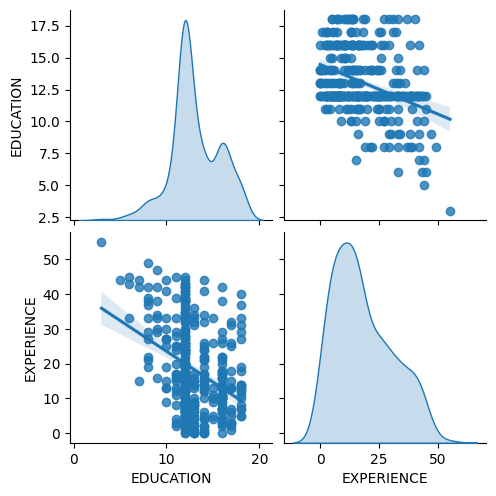

In [17]:
#Drop the AGE column because it is too closely related to EXPERIENCE
wages = wages.drop('AGE',axis=1)

X = wages.drop('WAGE', axis = 1)
y = wages['WAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

sns.pairplot(X_train, kind="reg", diag_kind="kde")


In [53]:
categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    (StandardScaler(), numerical_columns),
)

preprocessor2 = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
)

In [1]:
model1 = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=15), func=np.log10, inverse_func=sp.special.exp10
    ),
)

model1.fit(X_train,y_train)
model1_train_mse = mean_squared_error(y_train, model1.predict(X_train))
model1_test_mse = mean_squared_error(y_test, model1.predict(X_test))

feature_names = model1.named_steps['selector'].get_feature_names_out()
model1 = pd.DataFrame({'feature': feature_names})
print(sequential_features_df)

print(f'Train MSE: {model1_train_mse}')
print(f'Test MSE: {model1_test_mse}')
model1

NameError: name 'make_pipeline' is not defined

In [75]:
pis1 = permutation_importance(model1, X, y, n_repeats=10,random_state=0)
column_names = list(wages.columns)

for i in range(0,9):
    print(f'Importance for column {column_names[i]} is {pis1.importances_mean[i]} +/- {pis1.importances_std[i]}')

Importance for column EDUCATION is 0.2447018483221703 +/- 0.018207272805390858
Importance for column SOUTH is 0.013070627945489244 +/- 0.005569461592606399
Importance for column SEX is 0.054098253743196066 +/- 0.012087029003558469
Importance for column EXPERIENCE is 0.0781808355190352 +/- 0.008439599662684767
Importance for column UNION is 0.022017070246747327 +/- 0.007670225271549549
Importance for column WAGE is 0.00992951328066215 +/- 0.007789477726668144
Importance for column RACE is 0.07715906813661495 +/- 0.019027940959712795
Importance for column OCCUPATION is 0.007405452741761687 +/- 0.0019588768702491874
Importance for column SECTOR is 0.004052125792358341 +/- 0.002966109313680553


In [76]:
model2 = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Lasso(max_iter=100), func=np.log10, inverse_func=sp.special.exp10
    ),
)

model2.fit(X_train,y_train)
model2_train_mse = mean_squared_error(y_train, model2.predict(X_train))
model2_test_mse = mean_squared_error(y_test, model2.predict(X_test))

#feature_names = model1.named_steps['selector'].get_feature_names_out()
#model1 = pd.DataFrame({'feature': feature_names})
#print(sequential_features_df)

print(f'Train MSE: {model2_train_mse}')
print(f'Test MSE: {model2_test_mse}')
model2

Train MSE: 30.72885705158457
Test MSE: 21.22971547836934


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION',
                                                   'EXPERIENCE'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Lasso(max_iter=100)))])

In [77]:
pis = permutation_importance(model2, X, y, n_repeats=10,random_state=0)
column_names = list(wages.columns)

for i in range(0,9):
    print(f'Importance for column {column_names[i]} is {pis.importances_mean[i]} +/- {pis.importances_std[i]}')

Importance for column EDUCATION is 0.0 +/- 0.0
Importance for column SOUTH is 0.0 +/- 0.0
Importance for column SEX is 0.0 +/- 0.0
Importance for column EXPERIENCE is 0.0 +/- 0.0
Importance for column UNION is 0.0 +/- 0.0
Importance for column WAGE is 0.0 +/- 0.0
Importance for column RACE is 0.0 +/- 0.0
Importance for column OCCUPATION is 0.0 +/- 0.0
Importance for column SECTOR is 0.0 +/- 0.0


In [78]:
model3 = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LinearRegression(), func=np.log10, inverse_func=sp.special.exp10
    ),
)

model3.fit(X_train,y_train)
model3_train_mse = mean_squared_error(y_train, model3.predict(X_train))
model3_test_mse = mean_squared_error(y_test, model3.predict(X_test))

#feature_names = model1.named_steps['selector'].get_feature_names_out()
#model1 = pd.DataFrame({'feature': feature_names})
#print(sequential_features_df)

print(f'Train MSE: {model3_train_mse}')
print(f'Test MSE: {model3_test_mse}')
model3

Train MSE: 20.653800593449898
Test MSE: 14.907010157275115


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION',
                                                   'EXPERIENCE'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=LinearRegression()))])

In [79]:
pis1 = permutation_importance(model3, X, y, n_repeats=10,random_state=0)
column_names = list(wages.columns)

for i in range(0,9):
    print(f'Importance for column {column_names[i]} is {pis1.importances_mean[i]} +/- {pis1.importances_std[i]}')

Importance for column EDUCATION is 0.2236088449248065 +/- 0.019654407687608944
Importance for column SOUTH is 0.01322350374378245 +/- 0.006192403029834811
Importance for column SEX is 0.0637968082314689 +/- 0.014407354817006389
Importance for column EXPERIENCE is 0.08092828613539031 +/- 0.008503180432183366
Importance for column UNION is 0.02793097929890027 +/- 0.01038419502773523
Importance for column WAGE is 0.012594299369636908 +/- 0.009611867387208949
Importance for column RACE is 0.10198062288310972 +/- 0.025439166057733963
Importance for column OCCUPATION is 0.008667721586371701 +/- 0.00229326375198843
Importance for column SECTOR is 0.003408974392893427 +/- 0.003107784901511432


In [80]:
model4 = make_pipeline(
    preprocessor2,
    TransformedTargetRegressor(
        regressor=LinearRegression(), func=np.log10, inverse_func=sp.special.exp10
    ),
)

model4.fit(X_train,y_train)
model4_train_mse = mean_squared_error(y_train, model4.predict(X_train))
model4_test_mse = mean_squared_error(y_test, model4.predict(X_test))

#feature_names = model1.named_steps['selector'].get_feature_names_out()
#model1 = pd.DataFrame({'feature': feature_names})
#print(sequential_features_df)

print(f'Train MSE: {model4_train_mse}')
print(f'Test MSE: {model4_test_mse}')
model4

Train MSE: 23.054861539517876
Test MSE: 15.712938744795347


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=LinearRegression()))])

In [81]:
pis1 = permutation_importance(model4, X, y, n_repeats=10,random_state=0)
column_names = list(wages.columns)

for i in range(0,9):
    print(f'Importance for column {column_names[i]} is {pis1.importances_mean[i]} +/- {pis1.importances_std[i]}')

Importance for column EDUCATION is 0.0 +/- 0.0
Importance for column SOUTH is 0.017498582981859988 +/- 0.008186563469394755
Importance for column SEX is 0.07128112090995617 +/- 0.0179382355521618
Importance for column EXPERIENCE is 0.0 +/- 0.0
Importance for column UNION is 0.045145314321055695 +/- 0.013075631129835803
Importance for column WAGE is 0.016756301192009625 +/- 0.011160606546814247
Importance for column RACE is 0.2708294690711475 +/- 0.036911759735120314
Importance for column OCCUPATION is 0.015317215573532527 +/- 0.003858603583239811
Importance for column SECTOR is 0.006742577883251888 +/- 0.005029666781080022
